In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
sns.set()

In [2]:
dir_pth = {}
dir_pth['result'] = '/home/rohan/Remote-AI/dat/result/TE_Patchseq_Bioarxiv/'
dir_pth['logs'] = dir_pth['result']+'logs/'
dir_pth['checkpoints'] =dir_pth['result']+'checkpoints/'

In [3]:
%matplotlib inline

**Hyperparameter search results**: 
 - 9-fold cross validated mse reconstruction and coupling losses 
 - For `v2`: `1500` epochs for regular training followed by `500` steps of fine tuning

In [4]:
this_epoch=499
csTE_array = np.array([0.0,0.1,1.0,2.0,5.0])
aE_array = np.array([0.1,0.2,0.5,1.0,1.5,2.0])

T_recon_mean = np.empty((csTE_array.size,aE_array.size))
E_recon_mean = np.empty((csTE_array.size,aE_array.size))
M_recon_mean = np.empty((csTE_array.size,aE_array.size))
TE_dist_mean = np.empty((csTE_array.size,aE_array.size))

for i,csTE in enumerate(csTE_array):
    csTE = str(csTE).replace('.','-')
    for j,aE in enumerate(aE_array):
        aE = str(aE).replace('.','-')
        temp_T=[]
        temp_E=[]
        temp_M=[]
        temp_TE=[]
        for cv in range(9):
            file_id = 'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft.csv'
            D = pd.read_csv(dir_pth['logs']+file_id)
            epoch_ind=D['train_epoch'].values==this_epoch
            temp_T.extend(D['val_mse_T'].values[epoch_ind])
            temp_E.extend(D['val_mse_E'].values[epoch_ind])
            temp_M.extend(D['val_mse_M'].values[epoch_ind])
            temp_TE.extend(D['val_mse_TE'].values[epoch_ind])
        T_recon_mean[i,j]=np.mean(temp_T)
        E_recon_mean[i,j]=np.mean(temp_E)
        M_recon_mean[i,j]=np.mean(temp_M)
        TE_dist_mean[i,j]=np.mean(temp_TE)

In [5]:
def plot_heatmap(ax,M,Xarr,Yarr,Xlabel=r'$\lambda_{TE}$',Ylabel=r'$\alpha_{E}$',title='T recon'):
    im = ax.imshow(M.T)
    ax.set_xticks(np.arange(len(Xarr)))
    ax.set_yticks(np.arange(len(Yarr)))
    ax.set_xticklabels(Xarr)
    ax.set_yticklabels(Yarr)
    ax.set_xlabel(r'$\lambda_{TE}$')
    ax.set_ylabel(Ylabel)
    for i in range(Xarr.size):
        for j in range(Yarr.size):
            text = ax.text(i, j, '{:0.3f}'.format(M[i, j]),
                           ha="center", va="center", color="w")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.grid(False)
    ax.set_title(title)
    
    return

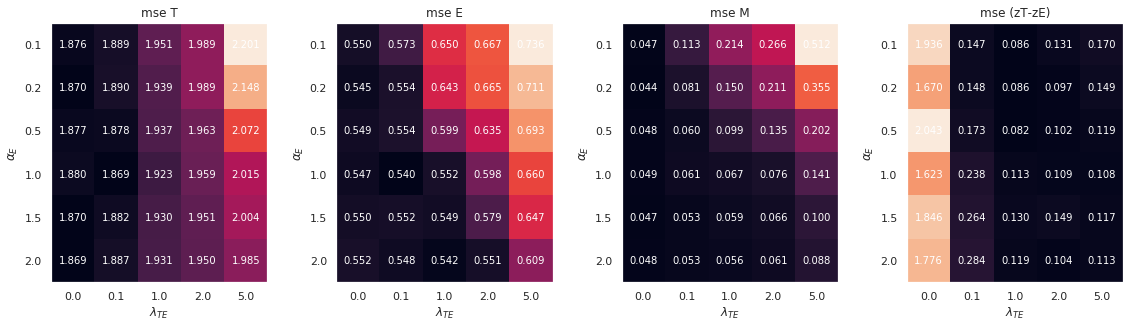

In [6]:
fig, ax = plt.subplots(1,4,figsize=(16,4.5))
plot_heatmap(ax=ax[0],M=T_recon_mean,Xarr=csTE_array,Yarr=aE_array,Xlabel=r'$\lambda_{TE}$',Ylabel=r'$\alpha_{E}$',title='mse T')
plot_heatmap(ax=ax[1],M=E_recon_mean,Xarr=csTE_array,Yarr=aE_array,Xlabel=r'$\lambda_{TE}$',Ylabel=r'$\alpha_{E}$',title='mse E')
plot_heatmap(ax=ax[2],M=M_recon_mean,Xarr=csTE_array,Yarr=aE_array,Xlabel=r'$\lambda_{TE}$',Ylabel=r'$\alpha_{E}$',title='mse M')
plot_heatmap(ax=ax[3],M=TE_dist_mean,Xarr=csTE_array,Yarr=aE_array,Xlabel=r'$\lambda_{TE}$',Ylabel=r'$\alpha_{E}$',title='mse (zT-zE)')
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Hyperparameter_search_1500_ep_v2_ft.png',dpi=300)

**Individual training curves**: Checks to determine if over-fitting is problematic.

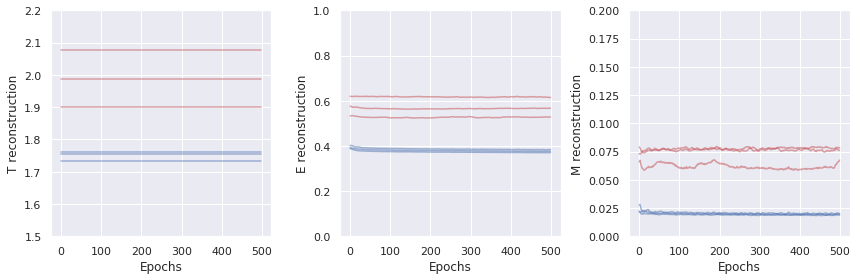

In [7]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
for cv in range(3):
    D = pd.read_csv(dir_pth['logs']+'v2_aT_1-0_aE_1-0_aM_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft.csv')
    plt.sca(ax[0])
    plt.plot(D['train_epoch'],D['train_mse_T'],'-b',alpha=0.5)
    plt.plot(D['val_epoch'],D['val_mse_T'],'-r',alpha=0.5)
    ax[0].set_ylabel('T reconstruction')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylim(1.5,2.2)
    
    plt.sca(ax[1])
    plt.plot(D['train_epoch'],D['train_mse_E'],'-b',alpha=0.5)
    plt.plot(D['val_epoch'],D['val_mse_E'],'-r',alpha=0.5)
    ax[1].set_ylabel('E reconstruction')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylim(0,1)
    
    plt.sca(ax[2])
    plt.plot(D['train_epoch'],D['train_mse_M'],'-b',alpha=0.5)
    plt.plot(D['val_epoch'],D['val_mse_M'],'-r',alpha=0.5)
    ax[2].set_ylabel('M reconstruction')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylim(0,0.2)
plt.tight_layout()

**Per feature reconstruction error**

In [8]:
raw_data_pth = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'

#E feature names (confirm with Nathan)
E_features_names = pd.read_csv(raw_data_pth+'sparse_pca_components_mMET_curated_Nov11_withheaders.csv')
E_features_names = E_features_names.columns[1:].values

#Full data matrices
O = sio.loadmat(raw_data_pth+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)

In [9]:
csTE = '1-0'
aE = '1-0'

X = np.empty(shape=(9,E_features_names.size))
Y = np.empty(shape=(9,E_features_names.size))
for cv in range(9):
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    X[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    Y[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE_from_XT'][D['val_ind'],:-1]),axis=0)    

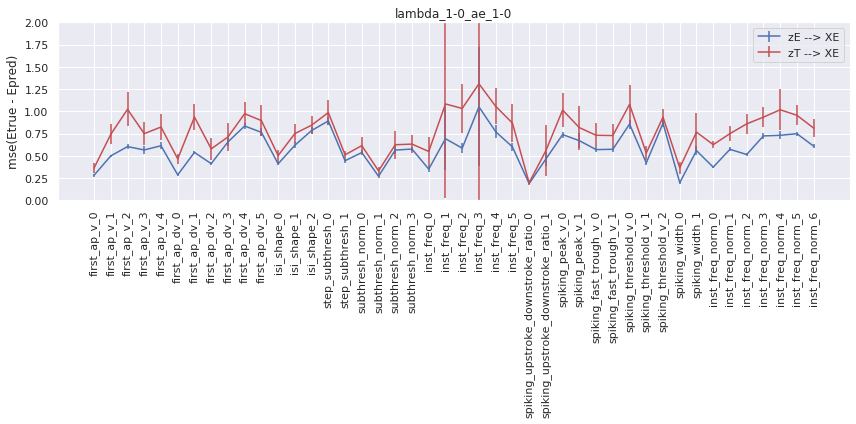

In [10]:
xx = np.arange(0,X.shape[1],1)

#With modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

#Cross modal prediction
yy2=np.mean(Y,axis=0)
err2=np.std(Y,axis=0)

fig = plt.figure(figsize=(12,6))
plt.errorbar(x=xx,y=yy,yerr=err,c='b',label='zE --> XE')
plt.errorbar(x=xx,y=yy2,yerr=err2,c='r',label='zT --> XE')
ax = plt.gca()
ax.set_xticks(np.arange(len(E_features_names)))
ax.set_xticklabels(E_features_names,rotation=90)
ax.set_ylabel('mse(Etrue - Epred)')
ax.set_ylim(0,2.0)
plt.legend()
plt.title('lambda_'+str(csTE)+'_ae_'+str(aE))
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epred_lambda_'+str(csTE)+'_ae_'+str(aE)+'_v2_ft.png',dpi=300)

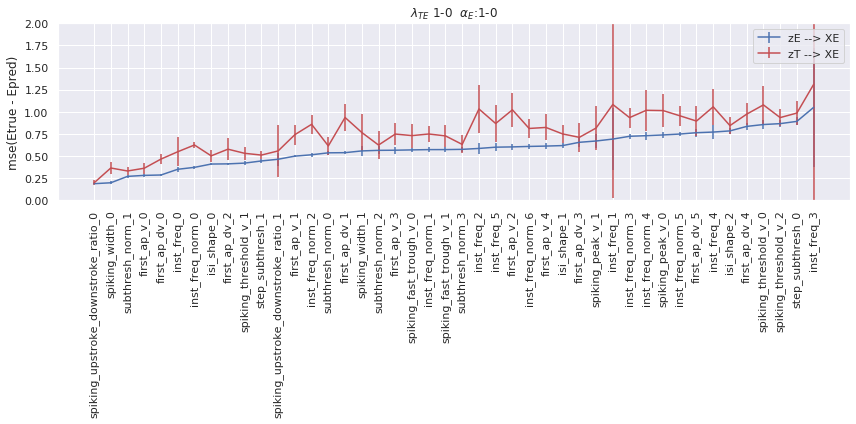

In [11]:
ind=np.argsort(yy)
fig = plt.figure(figsize=(12,6))
plt.errorbar(x=xx,y=yy[ind],yerr=err[ind],c='b',label='zE --> XE')
plt.errorbar(x=xx,y=yy2[ind],yerr=err2[ind],c='r',label='zT --> XE')
ax = plt.gca()
ax.set_xticks(np.arange(len(E_features_names)))
ax.set_xticklabels(E_features_names[ind],rotation=90)
ax.set_ylabel('mse(Etrue - Epred)')
ax.set_ylim(0,2.0)
plt.legend()
plt.title(r'$\lambda_{TE}$ '+str(csTE)+'  '+r'$\alpha_{E}$:'+str(aE))
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epredsorted_lambda_'+str(csTE)+'_ae_'+str(aE)+'_v2_ft.png',dpi=300)

In [12]:
aE = '1-0'

X = np.empty(shape=(9,E_features_names.size))
Y = np.empty(shape=(9,E_features_names.size))
Z = np.empty(shape=(9,E_features_names.size))
for cv in range(9):
    csTE = '1-0'    
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    X[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    
    csTE = '0-1'
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    Y[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    
    csTE = '0-0'
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    Z[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)

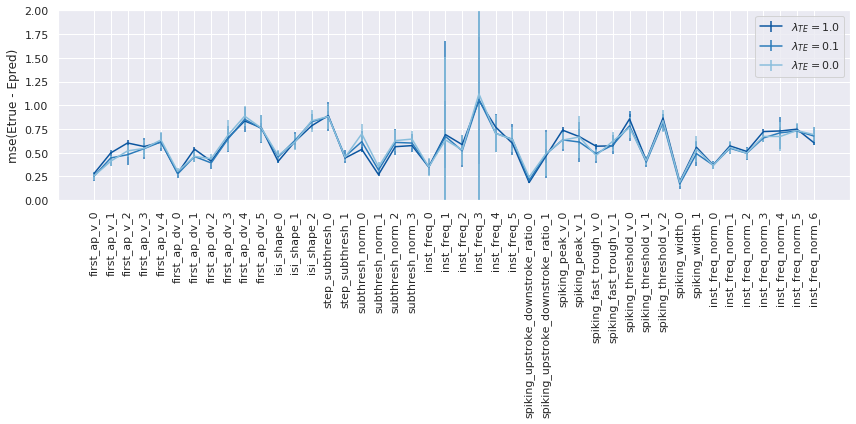

In [13]:
xx = np.arange(0,X.shape[1],1)

#Within modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

yy2=np.mean(Y,axis=0)
err2=np.std(Y,axis=0)

yy3=np.mean(Z,axis=0)
err3=np.std(Z,axis=0)

fig = plt.figure(figsize=(12,6))
p = (sns.color_palette("Blues"))
plt.errorbar(x=xx,y=yy,yerr=err,c=p[5],label=r'$\lambda_{TE}=1.0$')
plt.errorbar(x=xx,y=yy2,yerr=err2,c=p[4],label=r'$\lambda_{TE}=0.1$')
plt.errorbar(x=xx,y=yy3,yerr=err3,c=p[2],label=r'$\lambda_{TE}=0.0$')
ax = plt.gca()
ax.set_xticks(np.arange(len(E_features_names)))
ax.set_xticklabels(E_features_names,rotation=90)
ax.set_ylabel('mse(Etrue - Epred)')
ax.set_ylim(0,2.0)
plt.legend()
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epred_lambda_sweep_v2_ft.png',dpi=300)

**Representations**

In [14]:
import os
import fnmatch
import pprint

import numpy as np
import scipy.io as sio
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import HTML

def scatter3(X,col,xlims=(3,3),ylims=(3,3),zlims=(3,3)):
    sns.set_style("whitegrid")
    plt.ion()
    fig = plt.figure(figsize=(4,4))    
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X[:,0], X[:,1], X[:,2],s=1,alpha=1,c=col)

    ax.set_xticks([])
    ax.set_zticks([])
    ax.set_yticks([])
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    
    ax.set_xlim(xlims[0],xlims[1])
    ax.set_ylim(ylims[0],ylims[1])
    ax.set_zlim(zlims[0],zlims[1])

    plt.axis('on')
    ax.set_frame_on(False)
    plt.tight_layout()
    return ax,sc



In [15]:
csTE='1-0'
aE = '1-0'
cv=1

#Full data matrices
O = sio.loadmat(raw_data_pth+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)
D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)

xlims=(-2,3.3)
ylims=(-2,3.3)
zlims=(-2,3.3)
padval=-210
fontsizeval=10

In [16]:
%matplotlib inline

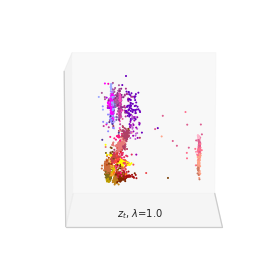

In [17]:
ax,sc = scatter3(D['zT'],O['cluster_color'],xlims,ylims,zlims)
ax.set_title(r'$z_t$, $\lambda$='+csTE.replace('-','.'),pad=padval,fontsize=fontsizeval)
fig = plt.gcf()

def update(i):
    ax.view_init(elev=10., azim=i)
    fig.canvas.draw()
    fig.canvas.flush_events()
    return

anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
HTML(anim.to_html5_video())

In [ ]:
anim.save('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/representation_T_z_'+csTE+'.gif', dpi=160, writer='imagemagick')

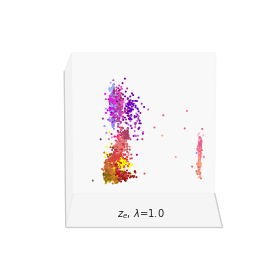

In [19]:
ax,sc = scatter3(D['zE'],O['cluster_color'],xlims,ylims,zlims)
ax.set_title(r'$z_e$, $\lambda$='+csTE.replace('-','.'),pad=padval,fontsize=fontsizeval)
fig = plt.gcf()

def update(i):
    ax.view_init(elev=10., azim=i)
    fig.canvas.draw()
    fig.canvas.flush_events()
    return

anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
HTML(anim.to_html5_video())

In [ ]:
anim.save('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/representation_E_z_'+csTE+'.gif', dpi=160, writer='imagemagick')